<a href="https://colab.research.google.com/github/guney1/LSTM_Stock_Prediction/blob/master/Optimized_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Get the required libaries

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [0]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from functools import partial
import talib
from sklearn.metrics import accuracy_score

In [0]:
tf.__version__

'1.13.1'

# Get the Data and Process it

In [0]:
start_date = '1970-12-31'
end_date = '2019-04-12'
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df_backtest = df.copy()
df_backtest["close_return"] = df_backtest["Close"].pct_change(1)
df_backtest["close_return_1df"] = df_backtest["close_return"].shift(-1)
df_backtest = df_backtest["'2017-09-06'":'2018-11-12']

In [0]:
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi_14"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)


In [0]:
df.head()

,High,Low,Open,Close,Volume,mid
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.514509
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.487723
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.452009
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.463170
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.476562


In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)


# Train valid test split
train_df_ = df_.iloc[:9000]
test_df_ = df_.iloc[9000:9200]
train_df = df.iloc[:9000]
test_df = df.iloc[9000:9200]
out_of_sample = df.iloc[9200:9500]
out_of_sample_ = df_.iloc[9200:9500]


# Seperate features and target for training data
train_data_X = np.array(train_df_.values)
train_data_y = np.array(train_df["return_1df"].values)
# Seperate for valid data
test_data_X = np.array(test_df_.values)
test_data_y = np.array(test_df["return_1df"].values)
# Seperate for test data
X_out_sample = np.array(out_of_sample_.values)
y_out_sample = np.array(out_of_sample["return_1df"].values)




In [0]:
out_of_sample_.index

DatetimeIndex(['2017-09-06', '2017-09-07', '2017-09-08', '2017-09-11',
               '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
               '2017-09-18', '2017-09-19',
               ...
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08',
               '2018-11-09', '2018-11-12'],
              dtype='datetime64[ns]', name='Date', length=300, freq=None)

In [0]:

# Windowized normalization
smoothing_window_size = 600

scaler_min = MinMaxScaler()
for di in range(0,9000,smoothing_window_size):
    scaler_min.fit(train_data_X[di:di+smoothing_window_size,:])
    train_data_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_data_X[di:di+smoothing_window_size,:])
    
test_data_X = scaler_min.transform(test_data_X)
X_out_sample = scaler_min.transform(X_out_sample)

In [0]:
df_.head()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,WMA,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cmo,dx,mfi,minus_di,minus_dm,plus_di,plus_dm,ppo,rsi_14,slowk,slowd,macd,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-03-13,0.396643,0.394311,0.396103,0.394311,57825600.0,0.398438,-0.011080,0.410682,0.440999,0.460174,0.444931,24.366149,24.292801,-0.015176,85.714286,35.714286,-50.0,-0.768486,-38.334758,39.850975,70.514252,63.133826,0.113761,27.153462,0.048928,-2.013960,30.832621,7.984110,3.646682,-0.027250,-0.023074,-0.004175,-107.374569,-0.071928,-0.074905,0.443977,0.435036,-15.963820,18.357990,-92.386079
1981-03-16,0.410724,0.406846,0.407246,0.406846,9307200.0,0.415179,0.042017,0.407115,0.439027,0.457383,0.441510,24.620529,24.439035,-0.015187,78.571429,28.571429,-50.0,-0.103196,-27.866453,27.927461,75.130095,57.494163,0.105636,32.391406,0.059514,-3.028580,36.066774,35.782640,15.574229,-0.026896,-0.023839,-0.003057,-68.883935,-0.049253,-0.068928,0.441515,0.428143,-14.487484,26.632867,-78.632733
1981-03-17,0.430983,0.426572,0.426524,0.426572,10936800.0,0.435268,0.048387,0.406455,0.438715,0.454900,0.439584,23.790460,23.769120,-0.015450,71.428571,21.428571,-50.0,0.010866,-13.332343,12.999568,76.281720,50.368470,0.098090,38.779605,0.075521,-3.680785,43.333828,62.788922,35.518557,-0.024739,-0.024019,-0.000720,-20.640111,-0.035178,-0.045737,0.439756,0.423569,-9.683741,34.270546,-56.989946
1981-03-18,0.457766,0.453209,0.453061,0.453209,9234400.0,0.462054,0.061538,0.409288,0.438912,0.452689,0.439491,22.312524,22.403950,-0.015784,64.285714,14.285714,-50.0,0.032468,2.743726,3.099356,77.507199,42.958219,0.091084,45.706247,0.096910,-3.712090,51.371863,88.709737,62.427100,-0.020642,-0.023343,0.002701,39.513024,-0.026212,-0.013996,0.438445,0.422170,-2.995760,47.509333,-27.764649
1981-03-19,0.461069,0.458173,0.459711,0.458173,9452800.0,0.456473,-0.012077,0.412570,0.439279,0.450674,0.439786,21.068704,21.083676,-0.015853,57.142857,7.142857,-50.0,-0.531024,5.435875,4.899036,78.482728,41.308942,0.084578,45.564924,0.093292,-3.771619,52.717937,92.798245,81.432301,-0.016801,-0.022035,0.005234,52.741112,-0.005699,-0.005352,0.438160,0.421635,-1.154680,53.671034,-22.318107


In [0]:
df.head()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,WMA,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cmo,dx,mfi,minus_di,minus_dm,plus_di,plus_dm,ppo,rsi_14,slowk,slowd,macd,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will,return_1df
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-03-13,0.396643,0.394311,0.396103,0.394311,57825600.0,0.398438,-0.011080,0.410682,0.440999,0.460174,0.444931,24.366149,24.292801,-0.015176,85.714286,35.714286,-50.0,-0.768486,-38.334758,39.850975,70.514252,63.133826,0.113761,27.153462,0.048928,-2.013960,30.832621,7.984110,3.646682,-0.027250,-0.023074,-0.004175,-107.374569,-0.071928,-0.074905,0.443977,0.435036,-15.963820,18.357990,-92.386079,0.042017
1981-03-16,0.410724,0.406846,0.407246,0.406846,9307200.0,0.415179,0.042017,0.407115,0.439027,0.457383,0.441510,24.620529,24.439035,-0.015187,78.571429,28.571429,-50.0,-0.103196,-27.866453,27.927461,75.130095,57.494163,0.105636,32.391406,0.059514,-3.028580,36.066774,35.782640,15.574229,-0.026896,-0.023839,-0.003057,-68.883935,-0.049253,-0.068928,0.441515,0.428143,-14.487484,26.632867,-78.632733,0.048387
1981-03-17,0.430983,0.426572,0.426524,0.426572,10936800.0,0.435268,0.048387,0.406455,0.438715,0.454900,0.439584,23.790460,23.769120,-0.015450,71.428571,21.428571,-50.0,0.010866,-13.332343,12.999568,76.281720,50.368470,0.098090,38.779605,0.075521,-3.680785,43.333828,62.788922,35.518557,-0.024739,-0.024019,-0.000720,-20.640111,-0.035178,-0.045737,0.439756,0.423569,-9.683741,34.270546,-56.989946,0.061538
1981-03-18,0.457766,0.453209,0.453061,0.453209,9234400.0,0.462054,0.061538,0.409288,0.438912,0.452689,0.439491,22.312524,22.403950,-0.015784,64.285714,14.285714,-50.0,0.032468,2.743726,3.099356,77.507199,42.958219,0.091084,45.706247,0.096910,-3.712090,51.371863,88.709737,62.427100,-0.020642,-0.023343,0.002701,39.513024,-0.026212,-0.013996,0.438445,0.422170,-2.995760,47.509333,-27.764649,-0.012077
1981-03-19,0.461069,0.458173,0.459711,0.458173,9452800.0,0.456473,-0.012077,0.412570,0.439279,0.450674,0.439786,21.068704,21.083676,-0.015853,57.142857,7.142857,-50.0,-0.531024,5.435875,4.899036,78.482728,41.308942,0.084578,45.564924,0.093292,-3.771619,52.717937,92.798245,81.432301,-0.016801,-0.022035,0.005234,52.741112,-0.005699,-0.005352,0.438160,0.421635,-1.154680,53.671034,-22.318107,0.012225


# Model Construction

In [0]:
X_train = train_data_X
y_train = train_data_y
X_test = test_data_X
y_test = test_data_y
X_out_sample = X_out_sample
y_out_sample = y_out_sample


In [0]:
n_steps = 20
n_inputs = X_train.shape[1]
num_nodes = 200
n_layers = 2
n_outputs = 1
# Reshape it for LSTM
X_test = X_test.reshape((-1, n_steps, n_inputs))
y_test = y_test.reshape((-1, n_steps, n_outputs))    
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
# initializers
he_init = tf.contrib.layers.variance_scaling_initializer()
he_init1 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN', uniform=True)
he_init2 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=True)
he_init3 = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG', uniform=False)
# Activations
tanh = tf.nn.tanh
elu = tf.nn.elu
leaky_relu = tf.nn.leaky_relu
# Construction
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
keep_prob = tf.placeholder_with_default(1.0, shape=())



cells = [tf.nn.rnn_cell.LSTMCell(num_units=num_nodes, use_peepholes=True, activation=tanh, initializer=he_init2) for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)


rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs_ = tf.reshape(rnn_outputs, [-1, num_nodes])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs_, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])


learning_rate = 0.005


loss = tf.reduce_mean(tf.square(outputs - y))

#Gradient clip for exploding gradient
threshold = 0.3
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs) # then apply it, normally minimize funtion do it all



init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_keep_prob = 0.7
max_checks_without_progress = 40
checks_without_progress = 0
best_loss = np.infty
n_iterations = 200
batch_size = 180
mse_train = []
mse_test = []
mse_out_ = []

In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Model Execution

In [0]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            y_batch = y_batch.reshape((-1, n_steps, n_outputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        mse_ = loss.eval(feed_dict={X: X_test, y: y_test, keep_prob: train_keep_prob})
        mse_out = loss.eval(feed_dict={X: X_out_sample, y: y_out_sample})
        mse_train.append(mse)
        mse_test.append(mse_)
        mse_out_.append(mse_out)
        print(iteration, "\tMSE:", mse, " MSE_TEST", mse_, " MSE_out", mse_out)
        if mse_ < best_loss: # adding stop loss
            save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
            best_loss = mse_
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break      


0 	MSE: 0.0037251955  MSE_TEST 0.007503976  MSE_out 0.004914066
1 	MSE: 0.000554826  MSE_TEST 0.002387003  MSE_out 0.001083493
2 	MSE: 0.0014920096  MSE_TEST 0.0016761615  MSE_out 0.00083571393
3 	MSE: 0.00081373006  MSE_TEST 0.00071003457  MSE_out 0.0006075612
4 	MSE: 0.0030048788  MSE_TEST 0.003181048  MSE_out 0.00057054136
5 	MSE: 0.0004925594  MSE_TEST 0.00020688158  MSE_out 0.0001560271
6 	MSE: 0.0007227783  MSE_TEST 0.00034420416  MSE_out 0.00027747938
7 	MSE: 0.00077245187  MSE_TEST 0.00019082935  MSE_out 0.00020573729
8 	MSE: 0.0007588352  MSE_TEST 0.0001627012  MSE_out 0.00019195321
9 	MSE: 0.0007264446  MSE_TEST 0.0001322736  MSE_out 0.00017939352
10 	MSE: 0.00054029666  MSE_TEST 0.00010223005  MSE_out 0.0001602185
11 	MSE: 0.00067573116  MSE_TEST 0.00018295344  MSE_out 0.00021737565
12 	MSE: 0.00059950235  MSE_TEST 0.00021417659  MSE_out 0.00023520242
13 	MSE: 0.0004781008  MSE_TEST 9.01303e-05  MSE_out 0.00013721132
14 	MSE: 0.00037250365  MSE_TEST 0.00013680478  MSE_out 0.

# Prediction

In [0]:
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    X_new = X_test
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    X_new_ = X_out_sample
    y_pred_out = sess.run(outputs, feed_dict={X: X_new_})

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5


# Results

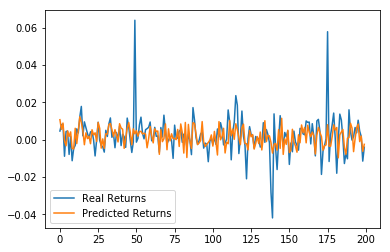

In [0]:
plt.plot(y_test.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred.reshape((-1, 1)), label = "Predicted Returns")
plt.legend()

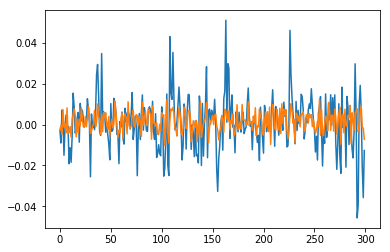

In [0]:
plt.plot(y_out_sample.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred_out.reshape((-1, 1)), label = "Predicted Returns")

In [0]:
comparison_change = pd.concat([pd.DataFrame(y_out_sample.reshape((-1, 1))), 
                        pd.DataFrame(y_pred_out.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.6866666666666666

In [0]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       133
           1       0.71      0.74      0.72       167

    accuracy                           0.69       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.69      0.69      0.69       300



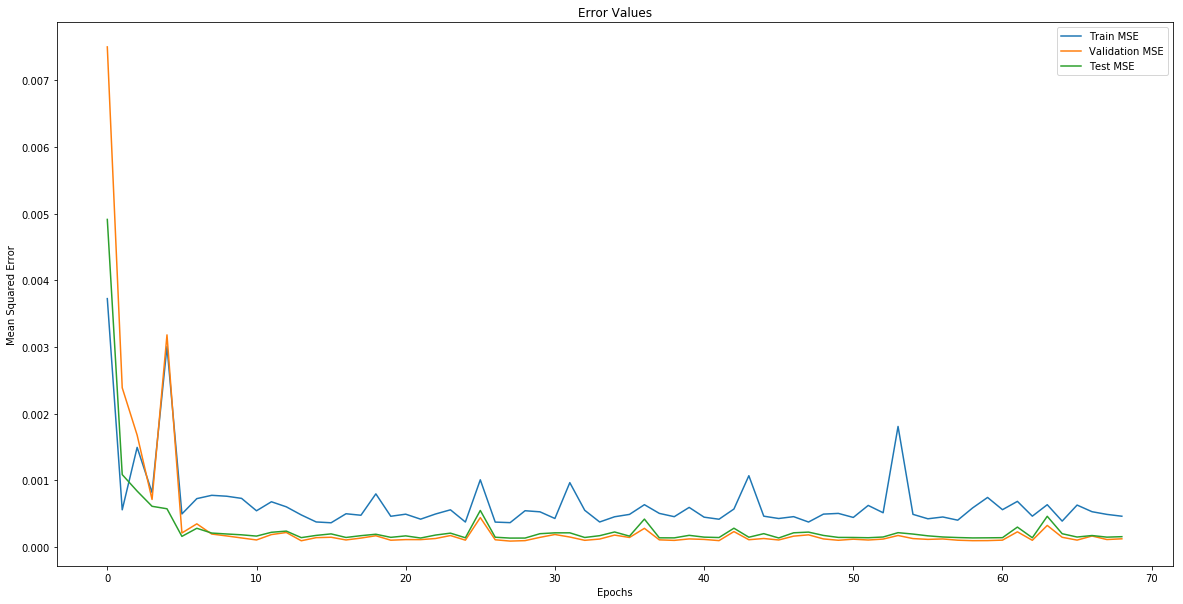

In [0]:
plt.figure(figsize=(20,10))
plt.title("Error Values")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(mse_train, label="Train MSE")
plt.plot(mse_test, label="Validation MSE")
plt.plot(mse_out_, label="Test MSE")
plt.legend()


# Backtest

In [0]:
df_backtest["signal"] = Suggestion
df_backtest["mid_return"] = df_backtest["mid"].pct_change(1)



In [0]:
df_backtest["pred_return"] = y_pred_out.reshape(-1, 1)
df_backtest["real_return"] = y_out_sample.reshape(-1, 1)


In [0]:
df_backtest.head()

,High,Low,Open,Close,Volume,mid,close_return,close_return_1df,pred_return,signal,mid_return,real_return
Date,,,,,,,,,,,,
2017-09-06,162.990005,160.520004,162.710007,161.910004,21651700.0,161.755005,-0.001049,-0.004015,-0.002795,-1,NaN,-0.002813
2017-09-07,162.240005,160.360001,162.089996,161.259995,21928500.0,161.300003,-0.004015,-0.016309,-0.000460,-1,-0.002813,-0.009051
2017-09-08,161.149994,158.529999,160.860001,158.630005,28611500.0,159.839996,-0.016309,0.018092,-0.004801,1,-0.009051,0.007070
2017-09-11,162.050003,159.889999,160.500000,161.500000,31580800.0,160.970001,0.018092,-0.003963,0.007317,1,0.007070,0.002454
2017-09-12,163.960007,158.770004,162.610001,160.860001,71714000.0,161.365005,-0.003963,-0.007522,-0.001184,1,0.002454,-0.015059


In [0]:
raw_prediction = y_pred_out.reshape(-1, 1)
Suggestion = []
percentChange = []


for d in range(len(raw_prediction)):
    percentChange.append(float((raw_prediction[d])))


    
for n in range(len(percentChange)):
    if (df_backtest["mid"][n]*(1+percentChange[n]))>df_backtest["Close"][n]:
        Suggestion.append(1) # buy if next day prediction higher
    elif (df_backtest["mid"][n]*(1+percentChange[n]))<df_backtest["Close"][n]:
        Suggestion.append(-1) # sell if next day prediction lower
    else:
        Suggestion.append(0) # hold otherwise

In [0]:
PurchaseHistory=[]
BuyPoints =  [[], []]
SellPoints = [[], []]
bought = False
for i in range(0, len(df_backtest)-1):
    if Suggestion[i] == 1 and not bought:
        PurchaseHistory.append(["Buy: ", df_backtest["Close"][i], i])
        BuyPoints[0].append(df_backtest["Close"][i])
        BuyPoints[1].append(i)
        bought = True
    if Suggestion[i] == -1 and bought:
        PurchaseHistory.append(["Sell:", df_backtest["Close"][i], i])
        SellPoints[0].append(df_backtest["Close"][i])
        SellPoints[1].append(i)        
        bought = False
if len(PurchaseHistory)%2 != 0:
    PurchaseHistory.pop()
    BuyPoints[0].pop()
    BuyPoints[1].pop() 

In [0]:
PurchaseHistory

[['Buy: ', 158.6300048828125, 2],
 ['Sell:', 159.64999389648438, 5],
 ['Buy: ', 159.8800048828125, 7],
 ['Sell:', 158.6699981689453, 8],
 ['Buy: ', 150.5500030517578, 13],
 ['Sell:', 153.27999877929688, 16],
 ['Buy: ', 154.47999572753906, 19],
 ['Sell:', 153.47999572753906, 20],
 ['Buy: ', 155.38999938964844, 21],
 ['Sell:', 159.75999450683594, 30],
 ['Buy: ', 156.25, 32],
 ['Sell:', 156.41000366210938, 35],
 ['Buy: ', 157.41000366210938, 36],
 ['Sell:', 163.0500030517578, 37],
 ['Buy: ', 166.88999938964844, 40],
 ['Sell:', 168.11000061035156, 41],
 ['Buy: ', 174.25, 43],
 ['Sell:', 175.8800048828125, 46],
 ['Buy: ', 173.97000122070312, 48],
 ['Sell:', 171.33999633789062, 49],
 ['Buy: ', 169.0800018310547, 50],
 ['Sell:', 174.08999633789062, 57],
 ['Buy: ', 169.8000030517578, 62],
 ['Sell:', 169.3699951171875, 66],
 ['Buy: ', 172.6699981689453, 67],
 ['Sell:', 173.97000122070312, 71],
 ['Buy: ', 176.4199981689453, 72],
 ['Sell:', 174.35000610351562, 74],
 ['Buy: ', 175.00999450683594, 

In [0]:
Profit = 0
for purchase in range(1, len(PurchaseHistory)+1, 2):
    MoneyMade = float(PurchaseHistory[purchase][1] - float(PurchaseHistory[purchase-1][1]))
    Profit += MoneyMade

print('$'+ str(round(Profit, 2)))

$79.92


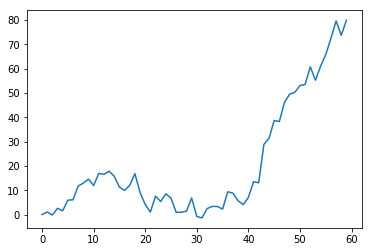

In [0]:
Profit_cum = [0]
for purchase in range(1, len(PurchaseHistory)+1, 2):
    MoneyMade = float(PurchaseHistory[purchase][1] - float(PurchaseHistory[purchase-1][1]))
    Profit_cum.append(MoneyMade)

plt.plot(np.array(Profit_cum).cumsum())
df_backtest["Close"].plot

In [0]:
# Total ROI
MinimumRequiredCapital = max(BuyPoints[0])
ROI = Profit / MinimumRequiredCapital * 100
print("Return on Investment:", round(float(ROI), 2),"%")

Return on Investment: 34.86 %


In [0]:
y_out_sample = y_out_sample.reshape(-1, 1)
y_pred_out = y_pred_out.reshape(-1, 1)

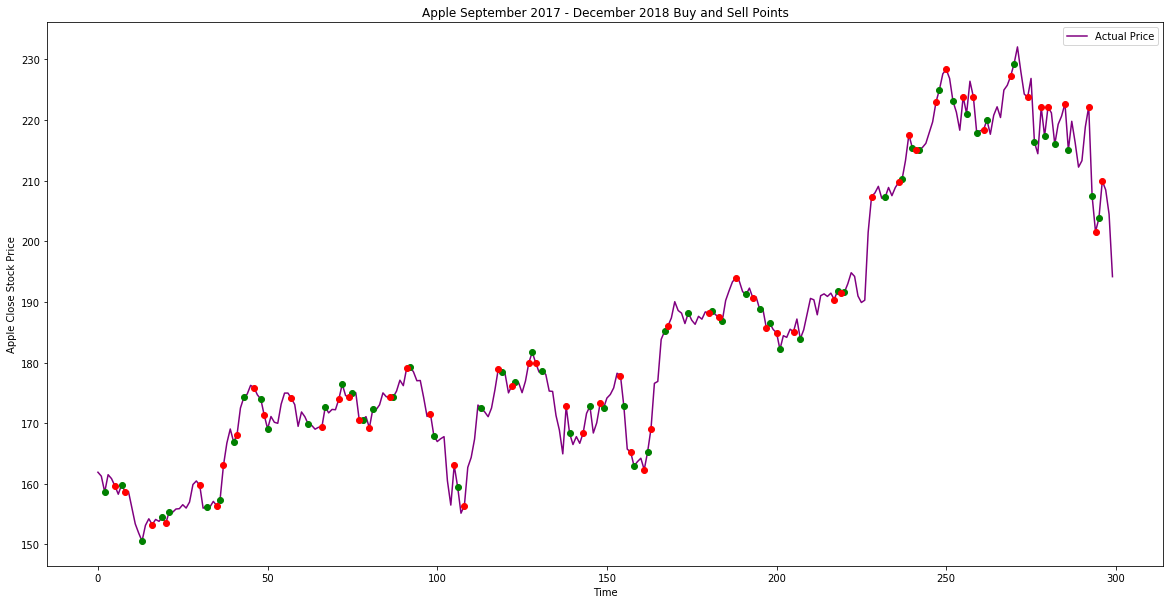

In [0]:
plt.figure(figsize=(20,10))
plt.plot(df_backtest["Close"].values, color =  'purple', label = "Actual Price")
#plt.plot(y_pred_out.reshape(-1, 1), color = 'blue', label = "Predicted Price")
plt.plot(BuyPoints[1], BuyPoints[0], "go")
plt.plot(SellPoints[1], SellPoints[0], "ro")

plt.title("Apple September 2017 - December 2018 Buy and Sell Points")
plt.xlabel('Time')
plt.ylabel('Apple Close Stock Price')
plt.legend()
plt.show()

In [0]:
# Benchmark, it is just buying and holding the stock
Benchmark = (df_backtest["Close"][-1] - df_backtest["Close"][0])/df_backtest["Close"][0] * 100
print("Benchmark:", round(float(Benchmark), 2),"%")

Benchmark: 19.92 %


# Test of the model on global data, Specifically I chosed to use small cap index, due to high volatility of the index we can test the generalization ability of the model better.

In [0]:

start_date = '1970-12-31'
end_date = '2019-04-12'
df = web.DataReader('IJR', 'yahoo', start_date, end_date)
df = df_scap.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)



In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)
df.index
df = df['2017-09-06':'2018-11-12']
df_ = df_['2017-09-06':'2018-11-12']

scap_data_X = np.array(df_.values)
scap_data_y = np.array(df["return_1df"].values)

In [0]:
scap_data_y = scap_data_y.reshape(-1, n_steps, 1)
scap_data_X = scaler_min.transform(scap_data_X.reshape(-1, 40))

In [0]:
scap_data_X = scap_data_X.reshape(-1, n_steps, 40)

In [0]:
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
    X_new = scap_data_X
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5


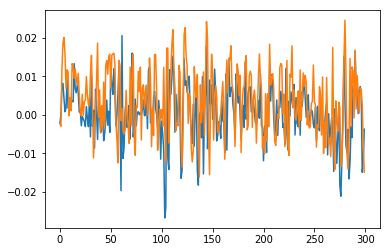

In [0]:
plt.plot(scap_data_y.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred.reshape((-1, 1)), label = "Predicted Returns")

In [0]:
comparison_change_scap = pd.concat([pd.DataFrame(scap_data_y.reshape((-1, 1))), 
                        pd.DataFrame(y_pred.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change_scap.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change_scap["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change_scap["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.6566666666666666

In [0]:
# Scores on scap index, better than expected, probably it will perform better on SP ETF or large cap index
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.65      0.52      0.58       135
           1       0.66      0.77      0.71       165

    accuracy                           0.66       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.66      0.66      0.65       300

